# Import Libraries

In [1]:
import torch

import pandas as pd

from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from timeit import default_timer as timer
from tqdm import tqdm

# Constants

In [3]:
EPOCHS = 500
LEARNING_RATE = 0.001

# Auxiliar Functions

In [4]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_pred)) * 100

    return acc

In [5]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device
):
    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [6]:
def test_step(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device
):
    test_loss, test_acc = 0, 0

    model.to(device)
    model.eval()

    with torch.inference_mode(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

In [7]:
def eval_model(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
    device: torch.device
):
    loss, acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss += loss_fn(y_pred, y)

            acc += accuracy_fn(y_pred.argmax(dim=1), y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_accuracy": acc
    }

# Data Acquisition

In [8]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")
print(f"Number of classes: {len(train_data.classes)}")

Number of training samples: 50000
Number of test samples: 10000
Number of classes: 10


In [10]:
CLASS_NAMES = train_data.classes

print(f"Classes: {CLASS_NAMES}")

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
CLASS_TO_IDX = train_data.class_to_idx

print(f"Class to index: {CLASS_TO_IDX}")

Class to index: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [12]:
image, label = train_data[0]

print(f"Image shape: {image.shape}")

Image shape: torch.Size([3, 32, 32])


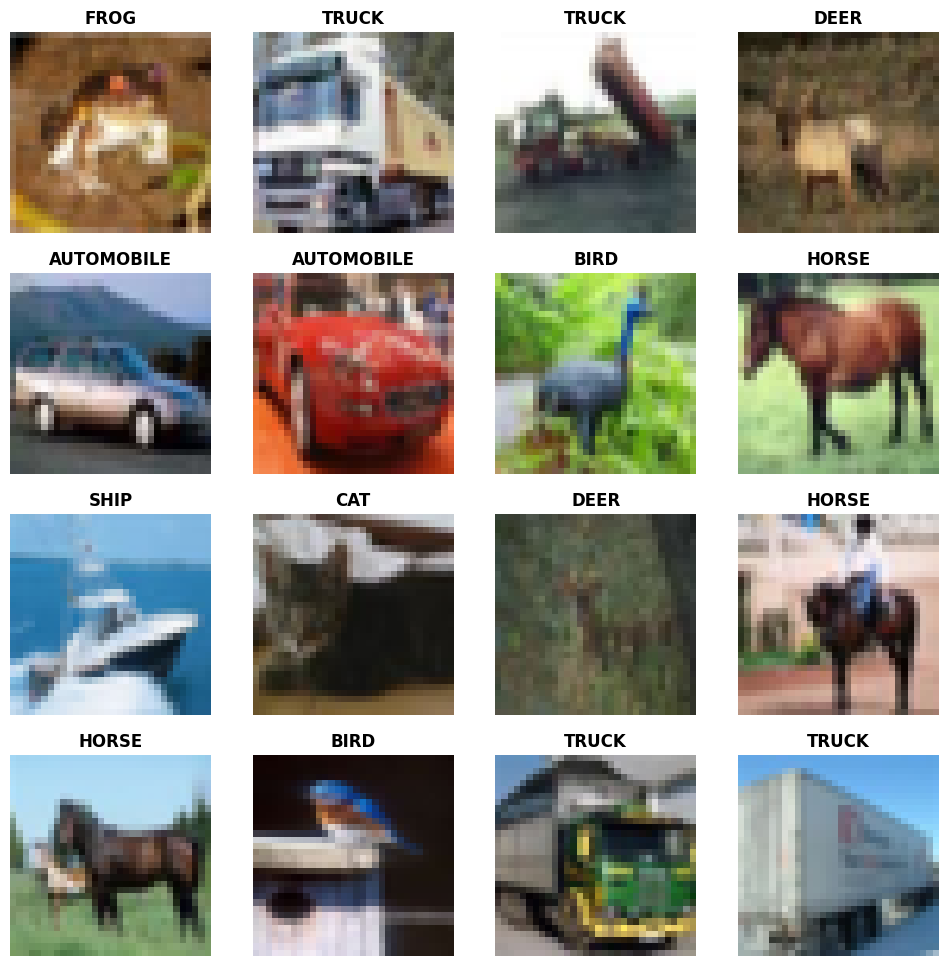

In [13]:
plt.figure(figsize=(12, 12))

for i in range(16):
    image, label = train_data[i]
    image_np = image.permute(1, 2, 0).numpy() # C x H x W -> H x W x C
    plt.subplot(4, 4, i + 1)
    plt.imshow(image_np)
    plt.title(CLASS_NAMES[label].upper(), fontweight="bold")
    plt.axis("off")

# Data Loader

In [14]:
BATCH_SIZE = 64

In [15]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=4
)

In [16]:
train_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [17]:
test_loader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [18]:
print(f"Number of training batches: {len(train_loader)}") # 50000 / 64 = 781.25
print(f"Number of test batches: {len(test_loader)}") # 10000 / 64 = 156.25

Number of training batches: 782
Number of test batches: 157


# Baseline Model

In [39]:
class CIFAR10_Model_V0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super(CIFAR10_Model_V0, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")

Device: cuda


In [41]:
torch.manual_seed(42)

model_v0 = CIFAR10_Model_V0(3 * 32 * 32, 128, 10).to(device)

model_v0

CIFAR10_Model_V0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v0.parameters(), lr=LEARNING_RATE)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch}\n--------------------------------------------------------------------------")
    train_step(
        model=model_v0,
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_step(
        data_loader=test_loader,
        model=model_v0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    print("-------------------------------------------------------------------------\n")

end_time = timer()

total_train_time_model_v0 = end_time - start_time

Epoch 0
--------------------------------------------------------------------------
Train loss: 2.23858 | Train accuracy: 19.03%
Test loss: 2.18352 | Test accuracy: 23.79%
-------------------------------------------------------------------------

Epoch 1
--------------------------------------------------------------------------
Train loss: 2.13931 | Train accuracy: 26.04%
Test loss: 2.09945 | Test accuracy: 27.51%
-------------------------------------------------------------------------

Epoch 2
--------------------------------------------------------------------------
Train loss: 2.06754 | Train accuracy: 28.76%
Test loss: 2.04052 | Test accuracy: 29.82%
-------------------------------------------------------------------------

Epoch 3
--------------------------------------------------------------------------
Train loss: 2.01775 | Train accuracy: 30.51%
Test loss: 1.99891 | Test accuracy: 30.78%
-------------------------------------------------------------------------

Epoch 4
--------

In [ ]:
model_v0_results = eval_model(
    model=model_v0,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

model_v0_results

100%|██████████| 157/157 [00:00<00:00, 229.06it/s]


{'model_name': 'CIFAR10_Model_V0',
 'model_loss': 1.3517602682113647,
 'model_accuracy': 52.189490445859875}

# CNN Model

In [ ]:
conv_layer = nn.Conv2d(
    in_channels=3,
    out_channels=16,
    kernel_size=3,
    stride=1,
    padding=1
)

conv_layer

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
torch.manual_seed(42)

images = torch.rand(size=(BATCH_SIZE, 3, 32, 32))
test_image = images[0]

print(images.shape)
print(test_image.shape)

torch.Size([64, 3, 32, 32])
torch.Size([3, 32, 32])


In [ ]:
output = conv_layer(images)

print(output.shape)

torch.Size([64, 16, 32, 32])


$$ O = \frac{W - K + 2P}{S} + 1 = \frac{32 - 3 + 2 * 1}{1} + 1 = 32$$

In [ ]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)

output = max_pool_layer(output)

output.shape

torch.Size([64, 16, 16, 16])

$$ O = \frac{W - K + 2P}{S} + 1 = \frac{32 - 2 + 2 * 0}{2} + 1 = 16$$

In [ ]:
class CIFAR10_Model_V1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super(CIFAR10_Model_V1, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 4 * 4,
                out_features=output_shape
            )
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")

Device: cuda


In [ ]:
model_v1 = CIFAR10_Model_V1(3, 32, 10).to(device)

model_v1

CIFAR10_Model_V1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v1.parameters(), lr=LEARNING_RATE)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch}\n--------------------------------------------------------------------------")
    train_step(
        model=model_v1,
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_step(
        data_loader=test_loader,
        model=model_v1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    print("-------------------------------------------------------------------------\n")

end_time = timer()

total_train_time_model_v1 = end_time - start_time

Epoch 0
--------------------------------------------------------------------------
Train loss: 2.30277 | Train accuracy: 11.60%
Test loss: 2.30198 | Test accuracy: 12.58%
-------------------------------------------------------------------------

Epoch 1
--------------------------------------------------------------------------
Train loss: 2.30145 | Train accuracy: 13.21%
Test loss: 2.30074 | Test accuracy: 13.39%
-------------------------------------------------------------------------

Epoch 2
--------------------------------------------------------------------------
Train loss: 2.30008 | Train accuracy: 14.63%
Test loss: 2.29918 | Test accuracy: 14.27%
-------------------------------------------------------------------------

Epoch 3
--------------------------------------------------------------------------
Train loss: 2.29838 | Train accuracy: 14.91%
Test loss: 2.29725 | Test accuracy: 14.70%
-------------------------------------------------------------------------

Epoch 4
--------

In [ ]:
model_v1_results = eval_model(
    model=model_v1,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

model_v1_results

100%|██████████| 157/157 [00:00<00:00, 238.81it/s]


{'model_name': 'CIFAR10_Model_V1',
 'model_loss': 0.8926740884780884,
 'model_accuracy': 69.90445859872611}

# VGG16

In [24]:
from torchvision.models import vgg16

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")

Device: cuda


In [32]:
model_v2 = vgg16(pretrained=True)

model_v2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
last_layer = model_v2.classifier[-1].in_features
model_v2.classifier[-1] = nn.Linear(in_features=last_layer, out_features=10)

model_v2 = model_v2.to(device)

In [34]:
loss_fn_v2 = nn.CrossEntropyLoss()
optimizer_v2 = torch.optim.SGD(params=model_v2.parameters(), lr=LEARNING_RATE)

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

for epoch in range(10):
    print(f"Epoch {epoch}\n-------------------------------------------------------------------------")
    train_step(
        model=model_v2,
        data_loader=train_loader,
        loss_fn=loss_fn_v2,
        optimizer=optimizer_v2,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_step(
        data_loader=test_loader,
        model=model_v2,
        loss_fn=loss_fn_v2,
        accuracy_fn=accuracy_fn,
        device=device
    )

    print("-------------------------------------------------------------------------\n")

end_time = timer()

total_train_time_model_v2 = end_time - start_time

Epoch 0
-------------------------------------------------------------------------
Train loss: 1.27142 | Train accuracy: 54.93%
Test loss: 0.87815 | Test accuracy: 69.03%
-------------------------------------------------------------------------

Epoch 1
-------------------------------------------------------------------------
Train loss: 0.73411 | Train accuracy: 74.31%
Test loss: 0.73167 | Test accuracy: 74.73%
-------------------------------------------------------------------------

Epoch 2
-------------------------------------------------------------------------
Train loss: 0.60922 | Train accuracy: 78.46%
Test loss: 0.64292 | Test accuracy: 77.62%
-------------------------------------------------------------------------

Epoch 3
-------------------------------------------------------------------------
Train loss: 0.53776 | Train accuracy: 81.02%
Test loss: 0.58308 | Test accuracy: 79.71%
-------------------------------------------------------------------------

Epoch 4
------------

In [37]:
model_v2_results = eval_model(
    model=model_v2,
    data_loader=test_loader,
    loss_fn=loss_fn_v2,
    accuracy_fn=accuracy_fn,
    device=device
)

model_v2_results

100%|██████████| 157/157 [00:05<00:00, 30.50it/s]


{'model_name': 'VGG',
 'model_loss': 0.48974740505218506,
 'model_accuracy': 83.54896496815287}

# Comparing

In [ ]:
compare_results = pd.DataFrame([
    model_v0_results,
    model_v1_results,
    model_v2_results
])

compare_results["training_time"] = [
    total_train_time_model_v0,
    total_train_time_model_v1,
    total_train_time_model_v2
]

compare_results

NameError: name 'model_v0_results' is not defined